In [1]:
from transformers import AutoModel, AutoTokenizer
from datasets import load_dataset, Dataset
import numpy as np
from einops import rearrange, reduce, repeat
import torch
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt

/mnt/swordfish-pool2/milad/conda-envs/huggingface-tlr/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MULTI_LUAR_PATH =  "/mnt/swordfish-pool2/milad/Multi-LUAR/src/reddit_model/"
LUAR_PATH =  "/mnt/swordfish-pool2/nikhil/LUAR/pretrained_weights/LUAR-MUD/"

In [3]:
# Load models
multiluar_model = AutoModel.from_pretrained(MULTI_LUAR_PATH, trust_remote_code=True)
luar_model = AutoModel.from_pretrained(LUAR_PATH, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained("rrivera1849/LUAR-MUD")

In [4]:
# Load data
style_distance_dataset = load_dataset('StyleDistance/synthstel')
style_distance_dataset_test = style_distance_dataset['test']

In [8]:
def get_embeddings(sentences, model, max_length=128, is_multi_luar=False):
    batch_size = 8
    max_length = max_length
    episode_length = int(max_length/32)
    num_batches = len(sentences)/batch_size
    sentences_embeddings = []
    with torch.no_grad():
        for batch_texts in np.array_split(sentences, num_batches):
            tokenized_text = tokenizer(
                batch_texts.tolist(), 
                max_length=max_length,
                padding="max_length", 
                truncation=True,
                return_tensors="pt"
            )
            #print(tokenized_text['input_ids'].shape)
            #print(tokenized_text['input_ids'][0])
            tokenized_text["input_ids"] = tokenized_text["input_ids"].reshape(batch_size, episode_length, -1)
            #print(tokenized_text['input_ids'].shape)
            #print(tokenized_text['input_ids'][0])
            #print(tokenized_text['input_ids'][1])
            tokenized_text["attention_mask"] = tokenized_text["attention_mask"].reshape(batch_size, episode_length, -1)
            #print(tokenized_text["input_ids"].size())       # torch.Size([batch_size, episode_length, max_length])
            #print(tokenized_text["attention_mask"].size())  # torch.Size([batch_size, episode_length, max_length])
        
            out = model(**tokenized_text)
            if is_multi_luar:
                out = rearrange(out, 'l b d -> b l d')
            sentences_embeddings.extend(out)

    return sentences_embeddings


def compute_similarities(x, y, layer=None):
    x = torch.cat([elem.unsqueeze(0) for elem in x])
    y = torch.cat([elem.unsqueeze(0) for elem in y])
        

    if layer == None:
        num_layers = x.shape[1]
        all_layer_similarities = []
        for layer in range(num_layers):
            layer_similarities = cosine_similarity(x[:, layer, :], y[:, layer, :])
            all_layer_similarities.append([layer_similarities])

        all_layer_similarities = np.concatenate(all_layer_similarities, axis=0)
        return all_layer_similarities.mean(axis=0)
    
    else:
        layer_similarities = cosine_similarity(x[:, layer, :], y[:, layer, :])
        return layer_similarities

def evalaute_diff_layers(x, y, labels, num_layers=7):
    table_res = []
    all_layers_sim = compute_similarities(x, y)
    layer_sims = {'all_layers': all_layers_sim}
    for layer_idx in range(num_layers):
        layer_sims['layer_{}'.format(layer_idx)] = layer_compute_similarities(x, y, layer_idx)
    return layer_sims

def compute_mrr(sim_matrix, labels):
    mrr_scores = []
    for idx, sen_similarities in enumerate(sim_matrix):
        sen_label = labels[idx]
        positive_sentences_indices = np.where(np.array(labels) == sen_label)[0]
        ranked_sentences = np.argsort(sen_similarities)[::-1].tolist()
        #print(ranked_sentences[:5])
        #print(positive_sentences_indices)
        #print()
        mrr_scores.append(np.max([1/(ranked_sentences.index(i)+1) for i in positive_sentences_indices if i !=idx]))
    avg_mrr_score = np.mean(mrr_scores)
    return avg_mrr_score

def merge_texts_to_authors_per_label(style_distance_dataset, num_authors_per_label):

    author_labels = set(style_distance_dataset['feature'])
    style_authors = [style_distance_dataset.filter(lambda row: row['feature'] == l) for l in author_labels]
    style_authors = [a.shard(num_authors_per_label, index=i) for a in style_authors for i in range(num_authors_per_label)] # spit the author into 3 sub-authors
    
    merged_dataset = []
    for a in style_authors:
        merged_dataset.append({
            'positive': '\n'.join(a['positive']),
            'negative': '\n'.join(a['negative']),
            'feature':  a['feature'][0]
        })
    
    author_ds = Dataset.from_list(merged_dataset)
    return author_ds

In [9]:
author_lvl_style_dataset= merge_texts_to_authors_per_label(style_distance_dataset['train'], 5)

In [10]:
np.max([len(x.split()) for x in author_lvl_style_dataset['negative']])

np.int64(320)

In [12]:
max_seq_length = 320 # longest sequence is 320
# Get embeddings from multi-luar
positives_embeddings = get_embeddings(author_lvl_style_dataset['positive'], multiluar_model, max_length=max_seq_length, is_multi_luar=True)
negatives_embeddings = get_embeddings(author_lvl_style_dataset['negative'], multiluar_model, max_length=max_seq_length, is_multi_luar=True)
labels = author_lvl_style_dataset['feature']

# Get embeddings from Luar
positives_luar_embeddings = get_embeddings(author_lvl_style_dataset['positive'], luar_model, max_length=max_seq_length,)
negatives_luar_embeddings = get_embeddings(author_lvl_style_dataset['negative'], luar_model, max_length=max_seq_length,)
positives_luar_embeddings = [e.unsqueeze(0) for e in positives_luar_embeddings]
negatives_luar_embeddings = [e.unsqueeze(0) for e in negatives_luar_embeddings]

In [13]:
# Compute Multi-luar similarity matrices at every layer and average of the layers
muti_luar_layers_sims = [compute_similarities(positives_embeddings, negatives_embeddings, layer=i) for i in range(7)]
muti_luar_layers_sims.append(compute_similarities(positives_embeddings, negatives_embeddings, layer=None))

In [14]:
# Compute Luar similarity matrices (only final layer)
luar_sim_matrix = compute_similarities(positives_luar_embeddings, negatives_luar_embeddings, layer=None)

In [15]:
compute_mrr(luar_sim_matrix, labels)

np.float64(0.07320800308634395)

In [16]:
[compute_mrr(s, labels) for s in muti_luar_layers_sims]

[np.float64(0.07167455537680283),
 np.float64(0.06319365159063581),
 np.float64(0.08331591937784813),
 np.float64(0.07768478463421541),
 np.float64(0.07759344107374488),
 np.float64(0.08221503414493499),
 np.float64(0.08185527954809788),
 np.float64(0.08156921874200056)]

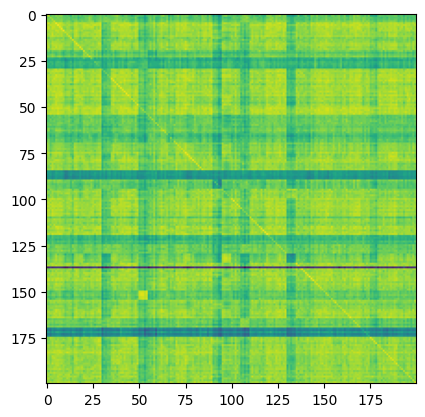

In [19]:
plt.imshow(muti_luar_layers_sims[1])
plt.show()

In [21]:
def compute_layer_to_features_significance(muti_luar_layers_sims, labels):
    layer_to_feat_score = []
    unique_labels = set(labels)
    for label in unique_labels:
        label_indices = np.where(np.array(labels) == label)[0]
        #print(label_indices)
        label_sims = []
        for layer in range(7):
            muti_luar_layer_sim = muti_luar_layers_sims[layer]
            label_matrix = np.take(muti_luar_layer_sim, label_indices, axis=0)
            label_matrix = np.take(label_matrix, label_indices, axis=1)
            #print(label_matrix)
            label_sims.append(round(float(np.mean(label_matrix)/np.mean(muti_luar_layer_sim)), 2))
        layer_to_feat_score.append(label_sims)
    return layer_to_feat_score

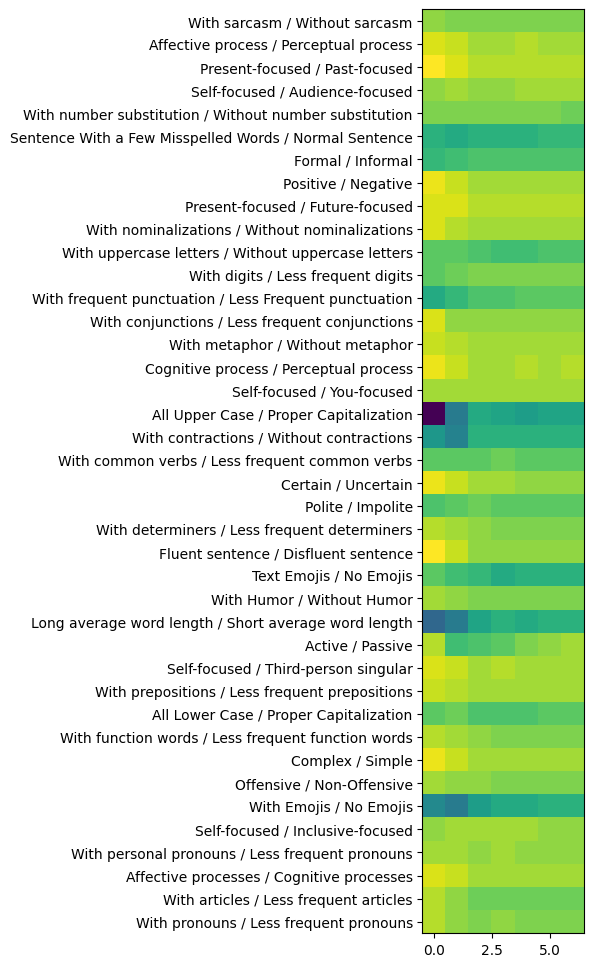

In [24]:
layer_to_feat_score = compute_layer_to_features_significance(muti_luar_layers_sims, labels)
fig, ax = plt.subplots(figsize=(6,12))
ax.imshow(layer_to_feat_score)
ax.set(yticks = range(len(set(labels))), yticklabels=set(labels))
plt.show()

### Clustering

In [163]:
from sklearn.manifold import TSNE

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def plot_tsne(embeddings, labels, layer):

    X =  np.array([elem.numpy() for elem in embeddings])
    X = X[:, layer, :]
    
    X_embedded = TSNE(n_components=2, learning_rate='auto',
                      init='random', perplexity=3).fit_transform(X)
    x = X_embedded[:,0]
    y = X_embedded[:,1]
    
    
    label_set = list(set(labels))
    color_map = get_cmap(len(label_set))
    label_set_colors = {x: color_map(i) for i, x in enumerate(label_set)}
    label_colors = [label_set_colors[label] for label in labels]
    
    sc = plt.scatter(x,y, c=label_colors)
    plt.show()

(80, 7, 512)


/tmp/ipykernel_1808632/4288906000.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  return plt.cm.get_cmap(name, n)


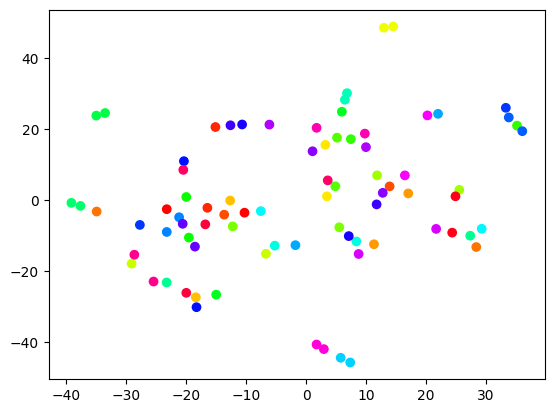

In [166]:
plot_tsne(positives_embeddings, labels, layer=6)